![Lapage](Lapage_logo.png)
# Contexte
Lapage était originellement une librairie physique avec plusieurs points de vente. 
Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. 
Vous intervenez car l’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc.

# Missions
- Réaliser une analyse des différents indicateurs de vente :
    - Le CA (indicateurs et graphiques) et son évolution dans le temps via la mise en place d'une décomposition en moyenne mobile pour évaluer la tendance globale;
    - Zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.;
    - Focus sur les profils des clients, et également la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.
- Fournir une analyse plus ciblée sur les clients : l’objectif serait cette fois-ci de comprendre le comportement de nos clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques. 
    - Etablir le lien entre le genre d’un client et les catégories des livres achetés.
    - Faire divers corrélations entre l’âge des clients et le montant total des achats, la fréquence d’achat, la taille du panier moyen et les catégories des livres achetés.



# Préparation des données 

## Initialisation du projet

### Import des librairies

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import datetime as dt

#Pour les analyses bivariées 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import bartlett
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr


### Paramètres

In [6]:
%matplotlib inline 
# On indique que l'on veut voir apparaître les graphiques dans le notebook, sinon on ne verrait rien

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 20)

### Import des fichiers

In [7]:
path='./Fichiers csv/'
customers_df = pd.read_csv(path+"customers.csv")
products_df=pd.read_csv(path+"products.csv")
transactions_df=pd.read_csv(path+"transactions.csv")

### Variables ou classes

Avant de commencer, je stocke le nombre de lignes et de colonnes de chacun des fichiers

In [8]:
customers_initial_size=customers_df.shape
products_intial_size=products_df.shape
transactions_intial_size=transactions_df.shape

In [9]:
def calculate_age_range(age):
    """
    This function creates an age range based on age.
    Parameters are :
    - age
    It returns
    - an age range
    """

    if 18 <= age <= 29:
        return "18-29"
    elif 30 <= age <= 44:
        return "30-44"
    elif 45 <= age <= 64:
        return "45-64"
    elif age >= 65:
        return "65 et +"


In [10]:
def assign_age_id(age):
    """
    This function affects an ID to a range age
    Parameters are :
    - age
    It returns
    - an ID
    """

    if 18 <= age <= 29:
        return 1
    elif 30 <= age <= 44:
        return 2
    elif 45 <= age <= 64:
        return 3
    elif age >= 65:
        return 4

## Analyse de la qualité des données

In [11]:
customers_df.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [12]:
products_df.tail()

,id_prod,price,categ
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1
3286,0_1920,25.16,0


In [13]:
transactions_df.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


### Erreurs de type

In [14]:
customers_df.dtypes

client_id    object
sex          object
birth         int64
dtype: object

In [15]:
products_df.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [16]:
transactions_df.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

<u>**Observation**</u><br>
La seule chose qui semble être problématique est la variable date qui n'est pas considérée comme une date. <br>
On peut corriger cela via la fonction to_datetime de pandas. <br>

<u>**Méthode**</u><br>
En lançant la commande de transformation du type object en date, on s'aperçoit que la conversion est bloquée par une erreur : "Unknown string format: test_2021-03-01 02:30:02.237419"<br>
Avant de relancer la conversion, j'identifie toutes les dates ayant le mot "test" et je les stocke dans un nouveau dataframe avant de les supprimer de mon fichier.
Je lance ensuite ma conversion au format date.

In [17]:
mask = np.column_stack([transactions_df["date"].str.contains("test", na=False) for col in transactions_df])
test_dates_transactions_df=transactions_df.loc[mask.any(axis=1)]
test_dates_transactions_df.head()

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0


In [18]:
transactions_df.drop(test_dates_transactions_df.index, inplace=True)

In [19]:
transactions_df.shape

(679332, 4)

In [20]:
transactions_df.date=pd.to_datetime(transactions_df.date)
transactions_df.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

### Valeurs manquantes

Je vérifier si mon jeu de données contient des valeurs manquantes (Null ou NaN)

In [21]:
customers_df.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [22]:
products_df.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [23]:
transactions_df.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

<u>**Observation**</u><br>
Il n'y a pas de valeurs NaN ou None

### Doublons

Pour identifier les doublons, je me base sur des clés qui ne devraient pas contenir d'informations en double<br>
- customer : le client_id doit être unique puisqu'il constitue la clé primaire;<br>
- products : le id_prod doit être unique puisqu'il constitue la clé primaire;<br>
- transactions : ce qui constituerait une transaction unique est l'ensemble id_prod + client_id + date.

In [24]:
customers_df.loc[customers_df["client_id"].duplicated(keep=False),:]

,client_id,sex,birth


In [25]:
transactions_df.loc[transactions_df[["id_prod","date","client_id"]].duplicated(keep=False)]

,id_prod,date,session_id,client_id


<u>**Observation**</u><br>
Il n'y a pas de doublon dans les données

### Détection d'anomalies

Un describe peut potentiellement nous aider dans un premier temps.<br>

In [26]:
customers_df.describe(include="all")

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_4410,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


<u>**Observation**</u><br>
Pour la table customer, rien ne semble anormal : les années de naissances vont de 1929 à 2004, et il n'y a que 2 valeurs pour le sexe.<br>

In [27]:
products_df.describe(include="all")

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


<u>**Observation**</u><br>
On note que la plus faible valeur est négative. Sans présumer de la valeur des livres, un prix négatif est forcément une erreur.

Recherche de prix négatifs ou valant 0

In [28]:
products_df[products_df.price<=0]

,id_prod,price,categ
731,T_0,-1.0,0


Le prix négatif a un id différent des autres car incluant une lettre. On pourrait assumer qu'il s'agit d'une erreur et supprimer cette ligne.
Je vérifie avant si je retrouve ce produit dans la table transaction qui est liée à la table products.

In [29]:
transactions_df[transactions_df.id_prod=="T_0"]

,id_prod,date,session_id,client_id


Je vérifie en passant si ce produit se trouve dans la table de test.

In [30]:
test_dates_transactions_df[test_dates_transactions_df=="T_0"].count()

id_prod       200
date            0
session_id      0
client_id       0
dtype: int64

Le produit est un produit test, il n'est pas présent dans la table transactions nettoyée. Je supprime la ligne.

In [31]:
products_df.drop(products_df[products_df.price<=0].index, inplace=True)

### Conclusion

Un type de données a été modifié.<br>
Aucune valeur manquante n'a été identifiée.<br>
Aucun doublon n'a été détecté.<br>
Des lignes ont été supprimées :
 - Les lignes de tests
 - Les lignes contenant des prix négatifs


In [32]:
customers_final_size=customers_df.shape
products_final_size=products_df.shape
transactions_final_size=transactions_df.shape

print (f"""
Le fichier 'customers.csv' contenait initialiement {customers_initial_size[0]} lignes et {customers_initial_size[1]} colonnes. 
Il contient maintenant {customers_final_size[0]} lignes et {customers_final_size[1]} colonnes. 

Le fichier 'products.csv' contenait initialiement {products_intial_size[0]} lignes et {products_intial_size[1]} colonnes. 
Il contient maintenant {products_final_size[0]} lignes et {products_final_size[1]} colonnes. 

Le fichier 'transactions.csv' contenait initialiement {transactions_intial_size[0]} lignes et {transactions_intial_size[1]} colonnes. 
Il contient maintenant {transactions_final_size[0]} lignes et {transactions_final_size[1]} colonnes. 
""")


Le fichier 'customers.csv' contenait initialiement 8623 lignes et 3 colonnes. 
Il contient maintenant 8623 lignes et 3 colonnes. 

Le fichier 'products.csv' contenait initialiement 3287 lignes et 3 colonnes. 
Il contient maintenant 3286 lignes et 3 colonnes. 

Le fichier 'transactions.csv' contenait initialiement 679532 lignes et 4 colonnes. 
Il contient maintenant 679332 lignes et 4 colonnes. 



# Analyse univariée des différents indicateurs de vente

Analyse univariée de l'ensemble des données de main_df

## Fusion des différents jeux de données

Pour faciliter la lecture des données, je merge toutes les données dans un seul tableau. Le tableau "principal" est transactions car il a les 2 clés étrangères des 2 autres tables.

In [33]:
main_df=(
    transactions_df
        .merge(customers_df, how="left")
        .merge(products_df, how="left")
)
main_df

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0.0
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,m,1988,15.99,1.0
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,f,1968,7.99,0.0
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,m,2000,69.99,2.0
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,m,1980,4.99,0.0
...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,f,1951,12.99,0.0
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,f,1977,10.99,1.0
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,f,1988,12.99,0.0
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,m,1986,4.98,0.0


Ayant réalisé une jointure gauche, je vérifie s'il y a des lignes nulles

In [34]:
null_rows=main_df[main_df.isnull().any(axis=1)]                          
print(f"Il y a {len(null_rows)} transactions dont au moins une valeur est nulle.")
if (len(null_rows) > 0):
    if int(len(null_rows.id_prod.unique())>1):
        print(f"{len(null_rows.id_prod.unique())} produits sont concernés : {','.join(str(i) for i in null_rows.id_prod.unique())}")
    else:
        print(f"Le produit concerné est {''.join(null_rows.id_prod.unique())}") 

Il y a 221 transactions dont au moins une valeur est nulle.
Le produit concerné est 0_2245


In [35]:
null_rows.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,m,1940,NaN,NaN
10103,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,f,1963,NaN,NaN
11723,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,m,1978,NaN,NaN
15670,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,m,1991,NaN,NaN
16372,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,m,1973,NaN,NaN


Je regarde dans quelles colonnes nous avons des valeurs de type NaN.

In [36]:
main_df.isnull().any(axis=0)

id_prod       False
date          False
session_id    False
client_id     False
sex           False
birth         False
price          True
categ          True
dtype: bool

Le produit a été vendu 221 fois, le supprimer nous ferait perdre des informations de CA pour notre analyse.<br>
Je vais appliquer le prix moyen au produit manquant, et la catégorie ayant le plus grand nombre d'occurences à la catégorie.

In [40]:
mean_price=np.mean(main_df.price)
most_numerous_categ = main_df.groupby("categ", as_index=False).agg({"categ":'count'}).reset_index().sort_values(by="categ",ascending=False)

print(f"""Le prix moyen d'un livre est de {mean_price:.2f}€.
La catégorie la plus représentée est la {most_numerous_categ.index[0]} avec {most_numerous_categ.categ[0]} occurences.""")

Le prix moyen d'un livre est de 17.45€.
La catégorie la plus représentée est la 0 avec 415680 occurences.


In [41]:
main_df.price.fillna(value=round(mean_price,2), inplace=True)
main_df.categ.fillna(value=most_numerous_categ.index[0], inplace=True)

Vérification de la modification

In [44]:
# I check my modification by searching the index of the 1st row of the array null_rows (index=2633).
main_df.iloc[2633]

id_prod                           0_2245
date          2022-09-23 07:22:38.636773
session_id                      s_272266
client_id                         c_4746
sex                                    m
birth                               1940
price                              17.45
categ                                0.0
Name: 2633, dtype: object

In [45]:
main_df.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
sex                   object
birth                  int64
price                float64
categ                float64
dtype: object

Le champ categ est devenu float au lieu d'un entier.<br>
Je modifie en int.

In [46]:
main_df.categ=main_df.categ.astype('int')
main_df.categ.dtypes

dtype('int64')

## Ajout de données

Pour les analyses demandées, je vais avoir besoin de décomposer la date d'achat et obtenir l'âge des clients.

Ajout de données issues de la colonne *date* : 
- année
- année-mois

In [47]:
main_df['purchase_year'] = main_df['date'].dt.year

In [48]:
main_df['purchase_month'] = main_df['date'].dt.strftime('%m')

In [49]:
main_df['purchase_year_month'] = main_df['purchase_year'].astype(str) + '-' + main_df['purchase_month'].astype(str)

In [50]:
main_df

,id_prod,date,session_id,client_id,sex,birth,price,categ,purchase_year,purchase_month,purchase_year_month
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,2022,05,2022-05
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,m,1988,15.99,1,2022,02,2022-02
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,f,1968,7.99,0,2022,06,2022-06
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,m,2000,69.99,2,2021,06,2021-06
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,m,1980,4.99,0,2023,01,2023-01
...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,f,1951,12.99,0,2022,01,2022-01
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,f,1977,10.99,1,2022,03,2022-03
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,f,1988,12.99,0,2022,12,2022-12
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,m,1986,4.98,0,2021,07,2021-07


Ajout d'une colonne *age* du client en fonction de l'année courante du jeu de données.

In [51]:
#Dataset has data in the future (2023 as we are in 2022).
#I can't retrieve the current year to compute age. I fetch max year from dataset.
#today = dt.date.today()
#currentYear=int(today.strftime("%Y")) : 
currentYear=max(main_df["date"].dt.year)
currentYear
main_df["age"]=currentYear-main_df.birth
main_df

,id_prod,date,session_id,client_id,sex,birth,price,categ,purchase_year,purchase_month,purchase_year_month,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,2022,05,2022-05,37
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,m,1988,15.99,1,2022,02,2022-02,35
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,f,1968,7.99,0,2022,06,2022-06,55
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,m,2000,69.99,2,2021,06,2021-06,23
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,m,1980,4.99,0,2023,01,2023-01,43
...,...,...,...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,f,1951,12.99,0,2022,01,2022-01,72
679328,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,f,1977,10.99,1,2022,03,2022-03,46
679329,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,f,1988,12.99,0,2022,12,2022-12,35
679330,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,m,1986,4.98,0,2021,07,2021-07,37


## Catégorie

### Nombre de ventes par catégorie

In [52]:
categ_data=main_df.groupby(["categ"])
categ_data=categ_data.size().reset_index(name='total')
categ_data

,categ,total
0,0,415680
1,1,227169
2,2,36483


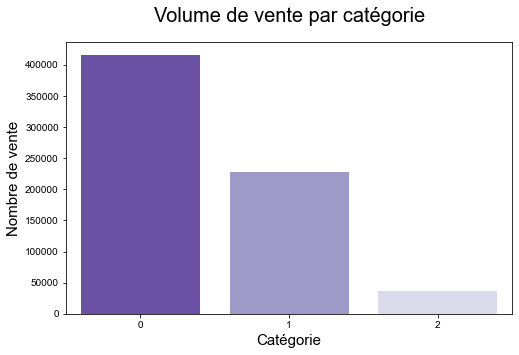

In [53]:
# Create graphic
plt.figure(figsize=(8,5))

sns.barplot(x="categ" , y="total",data=categ_data, palette = "Purples_r", saturation=1)
sns.set_theme(style="whitegrid")

plt.xlabel("Catégorie", fontsize = 15)
plt.ylabel("Nombre de vente", fontsize = 15)
plt.title("Volume de vente par catégorie", fontsize = 20,loc='center', pad=20)
#colors = sns.color_palette('colorblind')

# Show graphic
plt.show()

### Proportion des ventes par catégorie

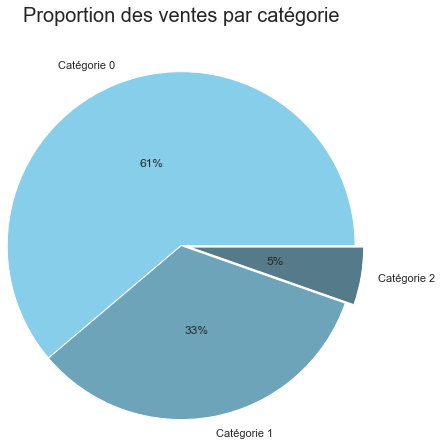

In [54]:
#Define Seaborn color palette to use
plt.tight_layout()
#colors = sns.color_palette(palette='pastel')[6:]
colors = sns.dark_palette("skyblue", 5, reverse=True)
plt.title('Proportion des ventes par catégorie',y=1.5, loc="center", size=20)
explode = [0, 0, 0.1]

#Data
data = categ_data.total
labels=categ_data.categ.apply(lambda x : "Catégorie " + str(x))

# Create and show pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%',pctdistance=0.5, radius=2, explode=explode)
plt.show()

### Total des ventes par catégorie

In [55]:
categ_price_data = main_df[["price","categ"]].groupby('categ').agg({"price":"sum"}).reset_index()
categ_price_data["price"]

0    4423587.42
1    4653722.69
2    2780275.02
Name: price, dtype: float64

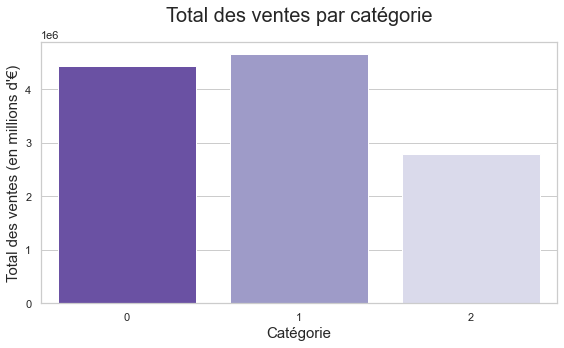

In [56]:
# Prepare graphic
plt.figure(figsize=(8,5))

sns.barplot(x="categ" , y="price",data=categ_price_data, palette = "Purples_r", saturation=1)
sns.set_theme(style="whitegrid")

plt.xlabel("Catégorie", fontsize = 15)
plt.ylabel("Total des ventes (en millions d'€)", fontsize = 15)
plt.title("Total des ventes par catégorie", fontsize = 20,loc='center', pad=20)
plt.tight_layout()

# Show graphic
plt.show()

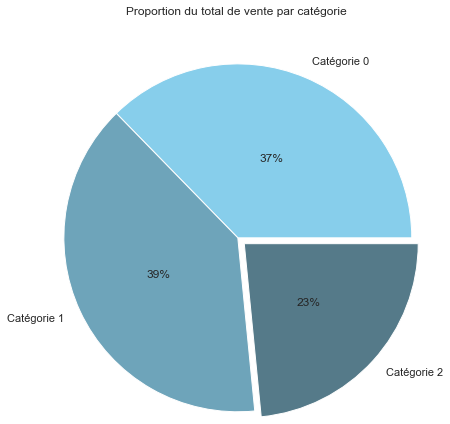

In [57]:
# Prepare graphic
plt.title('Proportion du total de vente par catégorie',y=1.5, loc="right")
#Define Seaborn color palette to use
colors = sns.dark_palette("skyblue", 5, reverse=True)
explode = [0, 0, 0.1]

#Data
data = categ_price_data.price
labels=categ_price_data.categ.apply(lambda x : "Catégorie " + str(x))

# Create and show pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%',pctdistance=0.5, radius=2, explode=explode)
plt.show()

### Top et flop 10 des produits par catégorie

In [58]:
top_flop=main_df[["id_prod", "price", "categ"]].groupby(['id_prod','categ',"price"], as_index=False).agg(sales=("categ","count"),total_sales=("price",'sum'))

In [61]:
top_flop=top_flop.sort_values(["sales","total_sales"], ascending=False)

#Top 10
top=top_flop.head(10)

# Moins de 1 vente pour un total de moins de 3€
flop=top_flop[(top_flop["total_sales"]<=3) & (top_flop["sales"]<=1)]

print (f"""Le top {len(top)} meilleures références est le suivant :

{top}
-----------------------------------------------
Les {len(flop)} moins bonnes ventes sont :

{flop}
""")

Le top 10 meilleures références est le suivant :

     id_prod  categ  price  sales  total_sales
2592   1_369      1  23.99   2252     54025.48
2645   1_417      1  20.99   2189     45947.11
2642   1_414      1  23.83   2180     51949.40
2734   1_498      1  23.37   2128     49731.36
2654   1_425      1  16.99   2096     35611.04
2630   1_403      1  17.99   1960     35260.40
2640   1_412      1  16.65   1951     32484.15
2641   1_413      1  17.99   1945     34990.55
2633   1_406      1  24.81   1939     48106.59
2634   1_407      1  15.99   1935     30940.65
-----------------------------------------------
Les 12 moins bonnes ventes sont :

     id_prod  categ  price  sales  total_sales
166   0_1151      0   2.99      1         2.99
417   0_1379      0   2.99      1         2.99
752   0_1683      0   2.99      1         2.99
1793   0_549      0   2.99      1         2.99
2109   0_833      0   2.99      1         2.99
549   0_1498      0   2.48      1         2.48
802   0_1728      0  

## Chiffre d'affaires

### Caclul du CA par année

In [62]:
price_data = main_df[["price", "purchase_year", "purchase_month", "purchase_year_month"]]
turnover_per_year=price_data.groupby("purchase_year").agg(turnover_per_year=("price","sum")).reset_index()
turnover_per_year

,purchase_year,turnover_per_year
0,2021,4772344.71
1,2022,6110775.81
2,2023,974464.61


<u>**Observation**</u><br>
Cette stat n'est pas pertinente car on ne sait pas combien mois composent les années extrêmes.<br>
Je calcul le CA mensuel et regroupe le CA par groupe de 12 mois pour avoir un CA lissé.

Calcul CA par mois

In [63]:
turnover_per_yearmonth=price_data.groupby("purchase_year_month").agg(turnover_per_yearmonth=("price","sum")).reset_index()
turnover_per_yearmonth

,purchase_year_month,turnover_per_yearmonth
0,2021-03,482597.66
1,2021-04,476353.60
2,2021-05,493083.07
3,2021-06,484210.71
4,2021-07,482905.20
5,2021-08,482441.84
6,2021-09,507450.08
7,2021-10,320920.89
8,2021-11,516342.23
9,2021-12,526039.43


In [64]:
'''
Rolling year calculation
Iterate over each row of the turnover_per_yearmonth dataframe.
If the modulo of the index of  "current line /12" equals 0, then we have reached 12 months, so we change the rolling year to the next one.
'''

j=min(turnover_per_year.purchase_year)
turnover_per_yearmonth["year"]=""
for i in range (0,len(turnover_per_yearmonth)):
    turnover_per_yearmonth.loc[turnover_per_yearmonth.index==i, "year"] = str(j)+"-"+str(j+1)
    if (i+1)%12==0: 
        j+=1

In [65]:
check_nb_months=turnover_per_yearmonth.groupby("year").agg(number_of_months=("year",'count')).reset_index()
turnover_per_yearmonth=turnover_per_yearmonth.merge(check_nb_months, how="inner")
turnover_per_yearmonth

,purchase_year_month,turnover_per_yearmonth,year,number_of_months
0,2021-03,482597.66,2021-2022,12
1,2021-04,476353.60,2021-2022,12
2,2021-05,493083.07,2021-2022,12
3,2021-06,484210.71,2021-2022,12
4,2021-07,482905.20,2021-2022,12
5,2021-08,482441.84,2021-2022,12
6,2021-09,507450.08,2021-2022,12
7,2021-10,320920.89,2021-2022,12
8,2021-11,516342.23,2021-2022,12
9,2021-12,526039.43,2021-2022,12


### Calcul CA sur 12 mois glissants

In [66]:
#check_nb_months.loc[check_nb_months.year=="2021-2022","number_of_month"]=11

#turnover_per_yearmonth.loc[turnover_per_yearmonth.year=="2021-2022", "number_of_month"]=11
#turnover_per_yearmonth


Je vérifie qu'il y a bien 12 mois par période, sinon je supprime les lignes pour ne pas les prendre en compte dans les graphes puisqu'on veut un CA annuel.

In [68]:
turnover_12_months=turnover_per_yearmonth.groupby(["year","number_of_months"]).agg(turnover_12_months=("turnover_per_yearmonth","sum")).reset_index()#retirer après df [["year","number_of_months","turnover_per_yearmonth"]]
turnover_12_months.drop(turnover_12_months.loc[turnover_12_months["number_of_months"]!=12].index,inplace=True)
turnover_12_months

,year,number_of_months,turnover_12_months
0,2021-2022,12,5833534.40
1,2022-2023,12,6024050.73


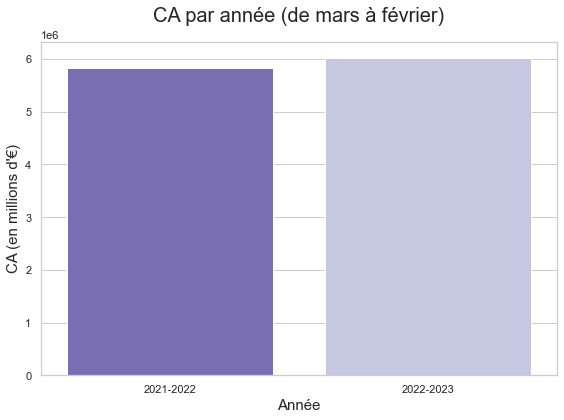

In [69]:
# Prepare graphic
plt.figure(figsize=(8,6))

sns.barplot(x="year" , y="turnover_12_months",data=turnover_12_months, palette = "Purples_r", saturation=1)
sns.set_theme(style="whitegrid")

plt.xlabel("Année", fontsize = 15)
plt.ylabel("CA (en millions d'€)", fontsize = 15)
plt.title("CA par année (de mars à février)", fontsize = 20,loc='center', pad=20)
plt.tight_layout()

# Show graphic
plt.show()

### Total des ventes mensuelles

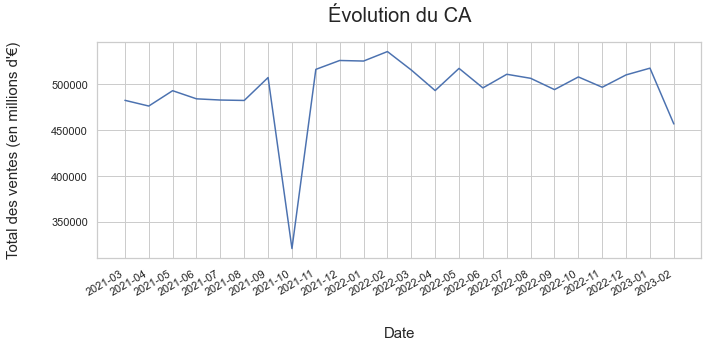

In [70]:
fig, ax = plt.subplots(figsize=(10, 5))

#Data
date = turnover_per_yearmonth["purchase_year_month"]
value=turnover_per_yearmonth["turnover_per_yearmonth"]

fig.autofmt_xdate()
ax.plot(date, value)

plt.xlabel("Date", fontsize = 15,labelpad=30)
plt.ylabel("Total des ventes (en millions d'€)", fontsize = 15,labelpad=30)
plt.title("Évolution du CA", fontsize = 20,loc='center', pad=20)
plt.tight_layout()

plt.show()

**Calcul de la moyenne mobile sur x mois**

Afin de lisser les données et avoir une idée de la tendance, on va utiliser la moyenne mobile sur 3 mois.

In [71]:
month=3
moving_average=turnover_per_yearmonth["turnover_per_yearmonth"].rolling(month, center=True).mean()
turnover_per_yearmonth["moving_average"]=moving_average
turnover_per_yearmonth

,purchase_year_month,turnover_per_yearmonth,year,number_of_months,moving_average
0,2021-03,482597.66,2021-2022,12,NaN
1,2021-04,476353.60,2021-2022,12,484011.443333
2,2021-05,493083.07,2021-2022,12,484549.126667
3,2021-06,484210.71,2021-2022,12,486732.993333
4,2021-07,482905.20,2021-2022,12,483185.916667
5,2021-08,482441.84,2021-2022,12,490932.373333
6,2021-09,507450.08,2021-2022,12,436937.603333
7,2021-10,320920.89,2021-2022,12,448237.733333
8,2021-11,516342.23,2021-2022,12,454434.183333
9,2021-12,526039.43,2021-2022,12,522602.633333


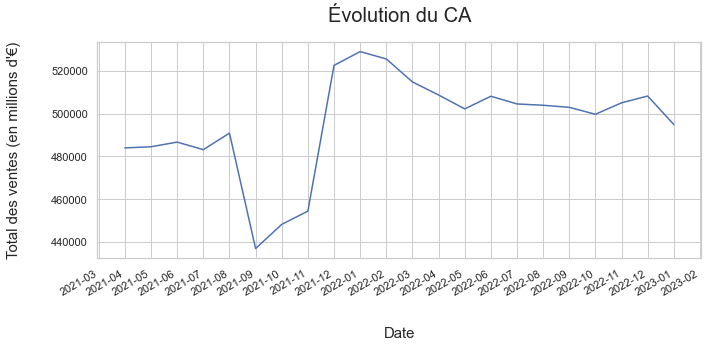

In [72]:
fig, ax = plt.subplots(figsize=(10, 5))

#Data
date = turnover_per_yearmonth["purchase_year_month"]
value=turnover_per_yearmonth["moving_average"]

fig.autofmt_xdate()
ax.plot(date, value)

plt.xlabel("Date", fontsize = 15,labelpad=30)
plt.ylabel("Total des ventes (en millions d'€)", fontsize = 15,labelpad=30)
plt.title("Évolution du CA", fontsize = 20,loc='center', pad=20)
plt.tight_layout()

plt.show()

Superposition des 2 courbes

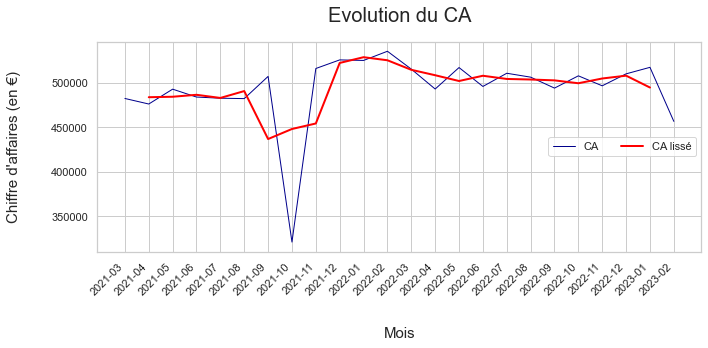

In [73]:
# Make a data frame with all data we're interesting in 
graph=pd.DataFrame({'x': turnover_per_yearmonth["purchase_year_month"], 'y1': turnover_per_yearmonth["turnover_per_yearmonth"],'y2': turnover_per_yearmonth["moving_average"]})

# set figure size
fig, ax = plt.subplots(figsize=(10, 5))
fig.autofmt_xdate(rotation=45)

# Rolling turnover graph + legend
plt.plot(graph['x'], graph['y1'], marker='', color="darkblue", linewidth=1, alpha=1, label="CA")

# Turnover graph + legend
plt.plot(graph['x'], graph['y2'], marker='', color="red", linewidth=2, alpha=1,label="CA lissé")

# Place legend
plt.legend(loc=5, ncol=2)

# Add titles
plt.title("Evolution du CA", loc='center', fontsize=20, fontweight=0, pad=20)
plt.xlabel("Mois",labelpad=30, fontsize=15)
plt.ylabel("Chiffre d'affaires (en €)",labelpad=30, fontsize=15)
plt.tight_layout()

#ax.set_ylim(bottom=0)#commencer le graphe à 0 sur l'axe y

# Show the graph
plt.show()
##9d9ac6 6a51a3

In [74]:
#A interpréter
turnover_12_months.mad() #: median absolute deviat

number_of_months          0.000
turnover_12_months    95258.165
dtype: float64

#A FAIRE SI TEMPS
Zoom sur le mois d'octobre qui enregistre une baisse du CA

In [75]:
turnover_per_day=price_data.groupby(pd.to_datetime(main_df['date']).dt.date).agg(turnover_per_day=("price","sum")).reset_index()
turnover_per_day.head()

,date,turnover_per_day
0,2021-03-01,16582.67
1,2021-03-02,15503.90
2,2021-03-03,15198.69
3,2021-03-04,15196.07
4,2021-03-05,17471.37


In [76]:
turnover_per_day

,date,turnover_per_day
0,2021-03-01,16582.67
1,2021-03-02,15503.90
2,2021-03-03,15198.69
3,2021-03-04,15196.07
4,2021-03-05,17471.37
...,...,...
725,2023-02-24,15207.89
726,2023-02-25,15761.25
727,2023-02-26,16304.72
728,2023-02-27,19170.81


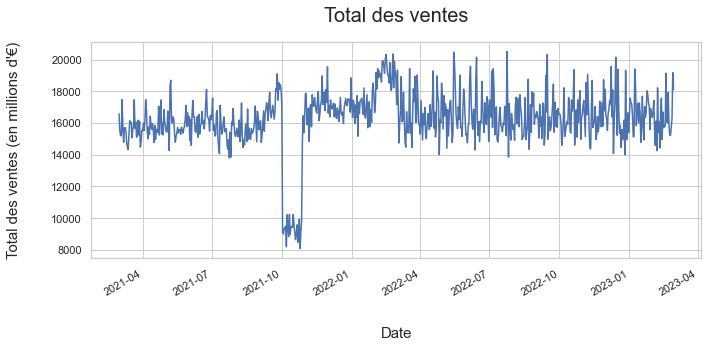

In [77]:
fig, ax = plt.subplots(figsize=(10, 5))

#half_year_locator = mdates.MonthLocator(interval=6)
#year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
#ax.xaxis.set_major_locator(half_year_locator)
#ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only


# Data
date= turnover_per_day["date"]
value=turnover_per_day["turnover_per_day"]

# Rotates and right aligns the x labels. 
# Also moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()

ax.plot(date, value)

plt.xlabel("Date", fontsize = 15,labelpad=30)
plt.ylabel("Total des ventes (en millions d'€)", fontsize = 15, labelpad=30)
plt.title("Total des ventes", fontsize = 20,loc='center', pad=20)
plt.tight_layout()

plt.show()

## Client

Calculs:<br>
- Sexe : Répartition homme/femme
- Age : Répartition par tranche d'âge

### Sexe

Mode opératoire :<br>
- Passer la colonne *sex* en minuscule
- Supprimer tous les doublons pour ne garder que les clients uniques
- Faire un group by par *sex*

In [78]:
#Convert data form "sex" in lower case
main_df["sex"]=main_df["sex"].str.lower()

In [79]:
clients_df=main_df.drop_duplicates(subset=["client_id","sex","age"])

distribution_by_gender=clients_df.groupby("sex").agg(number_of_clients=("sex","count")).reset_index()
number_of_w=distribution_by_gender["number_of_clients"][distribution_by_gender["sex"]=="f"].values[0]
number_of_m=distribution_by_gender[distribution_by_gender["sex"]=="m"]["number_of_clients"].values[0]

print(f"""A ce jour, la base de données est composée de {len(clients_df)} clients uniques dont {number_of_w} femmes et {number_of_m} hommes.
""")

A ce jour, la base de données est composée de 8600 clients uniques dont 4479 femmes et 4121 hommes.



#### Répartition Homme/Femme

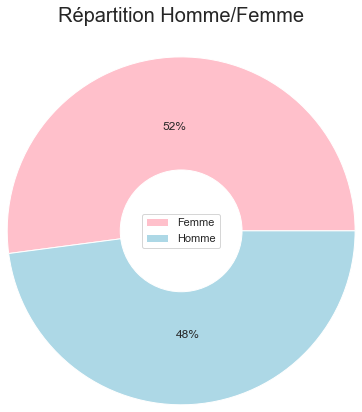

In [80]:
#Retrieving data
#Sex = distribution_by_gender["sex"] #not needed, used for labels but I hard coded the labels
distribution = distribution_by_gender["number_of_clients"]

# Create a white circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

colors = ['pink',"lightblue"]
labels=["Femme","Homme"]

#preparing the graph
plt.pie(distribution,colors=colors, labeldistance=0.5,autopct="%.0f%%", radius=2,pctdistance=0.6)

# from piechart to donut
p = plt.gcf()
p.gca().add_artist(my_circle)

#Legends and title
plt.title("Répartition Homme/Femme", pad=100, loc='center', fontsize=20)
plt.legend(labels, loc="center")

plt.show()

### Age

Mode opératoire :
- Vérification de la distribution de l'âge dans notre population
- Création de tranches en fonction des observations

In [81]:
clients_df

,id_prod,date,session_id,client_id,sex,birth,price,categ,purchase_year,purchase_month,purchase_year_month,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,2022,05,2022-05,37
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,m,1988,15.99,1,2022,02,2022-02,35
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,f,1968,7.99,0,2022,06,2022-06,55
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,m,2000,69.99,2,2021,06,2021-06,23
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,m,1980,4.99,0,2023,01,2023-01,43
...,...,...,...,...,...,...,...,...,...,...,...,...
542530,1_710,2021-06-23 21:15:17.278253,s_52829,c_5401,m,1984,27.94,1,2021,06,2021-06,39
566887,1_395,2021-06-21 15:15:34.079244,s_51791,c_3615,f,2004,28.99,1,2021,06,2021-06,19
567963,0_1509,2022-08-15 08:17:35.835342,s_253539,c_8114,m,1962,4.99,0,2022,08,2022-08,61
577591,1_152,2021-11-08 17:12:27.637349,s_116675,c_240,m,1998,11.06,1,2021,11,2021-11,25


In [82]:
client_by_age=clients_df.groupby("age").agg(occurence=("age","count")).reset_index().sort_values("occurence", ascending=False)
client_by_age

,age,occurence
0,19,437
25,44,215
16,35,207
18,37,203
26,45,199
24,43,191
22,41,191
12,31,186
36,55,181
8,27,179


Calcul de la modalité, de la moyenne et de la médiane de l' âge

In [83]:
mod_age=client_by_age.iloc[client_by_age['occurence'].idxmax(), 0]#Sortie de la 1ère colonne d'index ayant la valeur maximale de count.

median_age=np.median(clients_df.age)

mean_age=np.mean(clients_df.age)

print (f"L'âge le plus représenté est {mod_age} ans, l'âge médian se situe à {median_age:.0f} ans et la moyenne à {mean_age:.0f} ans.")

L'âge le plus représenté est 19 ans, l'âge médian se situe à 44 ans et la moyenne à 45 ans.


In [84]:
clients_df.age.describe()

count    8600.000000
mean       44.739302
std        16.908755
min        19.000000
25%        31.000000
50%        44.000000
75%        57.000000
max        94.000000
Name: age, dtype: float64

<u>**Observation**</u><br>
L'âge le plus représenté est aussi l'âge minimum

Vérification de l'existence d'outlier sur l'âge

In [85]:
q1_age=np.median(clients_df[clients_df.age<=median_age]["age"])
q3_age=np.median(clients_df[clients_df.age>median_age]["age"])
iqr_age=q3_age-q1_age
outlier_q1_age=q1_age-(1.5*iqr_age)
outlier_q3_age=q3_age+(1.5*iqr_age)

print(f"""Les outliers d'âge sont fixés à {outlier_q1_age} et {outlier_q3_age} ans
L'âge minimal de notre jeu de données est {min(clients_df.age)} ans et l'âge maximal {max(clients_df.age)} ans.""")
if outlier_q1_age<min(clients_df.age):
    print (f"Il n'y a pas d'outlier sur l'âge minimum.")
else :
    print (f"On trouve au moins un âge dans ce que l'on considère comme outlier")
if outlier_q3_age>max(clients_df.age):
    print (f"Il n'y a pas d'outlier sur l'âge maximum.")
else :
    print (f"On trouve au moins un âge supérieur à un outlier ")

Les outliers d'âge sont fixés à -8.0 et 96.0 ans
L'âge minimal de notre jeu de données est 19 ans et l'âge maximal 94 ans.
Il n'y a pas d'outlier sur l'âge minimum.
Il n'y a pas d'outlier sur l'âge maximum.


Création de 4 tranches d'âge :
- 18-29 ans
- 30-44 ans
- 45-64 ans
- 65 ans et +

In [86]:
main_df["age_range"]=main_df.age.apply(calculate_age_range)

In [87]:
turnover_by_age=main_df.groupby('age_range').agg(turnover_by_age=('price','sum')).reset_index()
turnover_by_age

,age_range,turnover_by_age
0,18-29,2884757.92
1,30-44,4203935.26
2,45-64,3621970.12
3,65 et +,1146921.83


#### Répartition du CA par catégorie d'âge

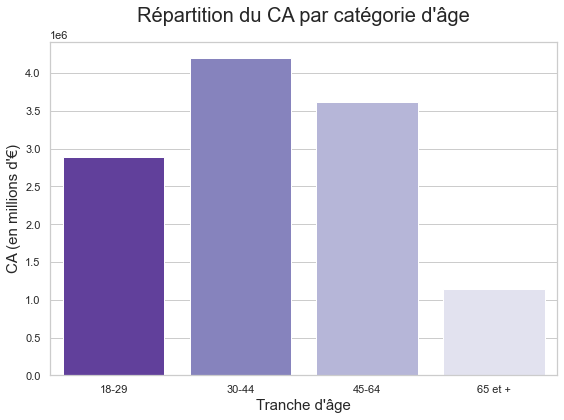

In [88]:
# Prepare graphic
plt.figure(figsize=(8,6))

sns.barplot(x="age_range" , y="turnover_by_age",data=turnover_by_age, palette = "Purples_r", saturation=1)
sns.set_theme(style="whitegrid")

plt.xlabel("Tranche d'âge", fontsize = 15)
plt.ylabel("CA (en millions d'€)", fontsize = 15)
plt.title("Répartition du CA par catégorie d'âge", fontsize = 20,loc='center', pad=20)
plt.tight_layout()

# Plot graphic
plt.show()

### Age et sexe

**Répartition par tranche d'âge et sexe**

In [136]:
turnover_by_age_and_sex=main_df.groupby(['age_range','sex']).agg(turnover_by_age_sex=('price','sum')).reset_index()
turnover_by_age_and_sex

,age_range,sex,turnover_by_age_sex
0,18-29,f,1350705.69
1,18-29,m,1534052.23
2,30-44,f,1962577.97
3,30-44,m,2241357.29
4,45-64,f,1919314.78
5,45-64,m,1702655.34
6,65 et +,f,629126.34
7,65 et +,m,517795.49


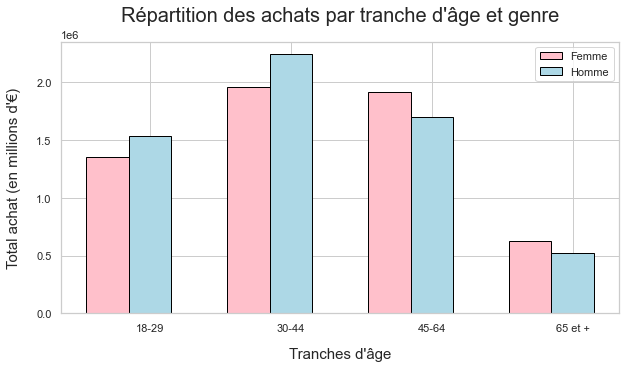

In [137]:
fig = plt.subplots(figsize=(10, 5))

# width of the bars
barWidth = 0.3
 
# Determine the height of the women bars
w_bars = turnover_by_age_and_sex["turnover_by_age_sex"][turnover_by_age_and_sex["sex"]=="f"]
 
# Determine the height of the men bars
m_bars = turnover_by_age_and_sex["turnover_by_age_sex"][turnover_by_age_and_sex["sex"]=="m"]

# The x position of bars
r1 = np.arange(len(w_bars))
r2 = [x + barWidth for x in r1]
 
# Create women bars
plt.bar(x=r1, height=w_bars, width =barWidth, color = 'pink', edgecolor = 'black', label='Femme')
 
# Create men bars
plt.bar(x=r2, height=m_bars, width = barWidth,  color = 'lightblue', edgecolor = 'black',   label='Homme')
 
# general layout
plt.xticks(ticks=[r + barWidth for r in range(len(m_bars))], labels=[turnover_by_age_and_sex["age_range"][turnover_by_age_and_sex["sex"]=="m"]][0])
plt.ylabel("Total achat (en millions d'€)", fontsize = 15,labelpad=15)
plt.xlabel("Tranches d'âge", fontsize = 15,labelpad=15)
plt.title("Répartition des achats par tranche d'âge et genre", fontsize = 20,loc='center', pad=20)
plt.legend()
 
# Show graphic
plt.show()

### Analyse de la concentration des dépenses

Permet de regarder si l'argent dépensé sur le site est réparti de manière égalitaire ou pas par les clients.

Méthode : 
- Courbe de Lorenz
- Calcul de l'indice de Geni (surface entre 1ère bissectrice et la courbe de Lorenz)

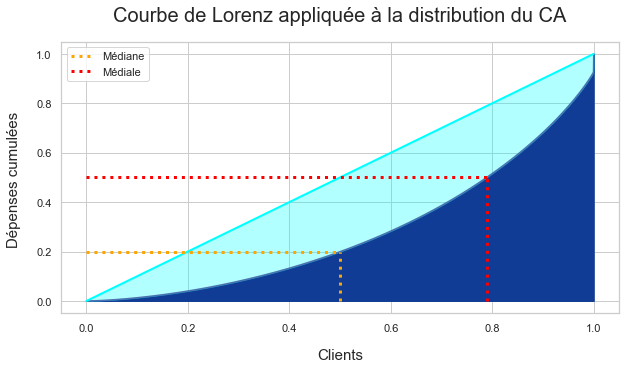

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))

# Lorenz curve
expenses=main_df.groupby("client_id")["price"].sum()
n = len(expenses) #number of unique clients

lorenz = (np.cumsum(np.sort(expenses)) / expenses.sum())  # cumulative sum on the sorted dataset
lorenz = np.append([0],lorenz) # Lorenz curve starts at 0, I add 0 on dataset

xaxis = np.linspace(0,1,n+1) # axis goes from 0 to 1. Formula to get evenly spaced number linspace (start=x1, stop=x2, numberOfDots=n) -> space between each dot is (x2-x1) / (n-1)

plt.plot(xaxis,lorenz)

#Drawing the bisector
plt.plot([0, 1], [0, 1], color='cyan', linestyle='-', linewidth=2) 
plt.ylabel('Dépenses cumulées ', fontsize = 15,labelpad=15)
plt.xlabel("Clients", fontsize = 15,labelpad=15)
plt.title("Courbe de Lorenz appliquée à la distribution du CA", fontsize = 20,loc='center', pad=20)


ax.fill_between(xaxis, lorenz, color="#103c95")
ax.fill_between(xaxis, xaxis, lorenz, color='cyan', alpha=0.3)

# Calculation and positionning of the median and medial
median = lorenz[int(round(len(lorenz)) / 2)] # retrievieng the value at half of the dataset
plt.plot([0.5, 0.5], [0, median], color='orange', linestyle=':', linewidth=3, label="Médiane")
plt.plot([0, 0.5], [median, median], color='orange', linestyle=':', linewidth=3)

medial = len(lorenz[lorenz <= 0.5]) / len(lorenz) # medial is found at half of the height
plt.plot([0, medial], [0.5, 0.5], color='red', linestyle=':', linewidth=3, label="Médiale")
plt.plot([medial, medial], [0, 0.5], color='red', linestyle=':', linewidth=3)

ax.legend(loc="best")
plt.show()

Calcul de l'indice de Gini

In [97]:
lorenz=lorenz #gini is expressed by a number varying between 0 and 1.
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n #Area unbder Lorenz curve. The 1st segment (lorenz[0]) is half below 0, we cut it in half, and we do the same with the last segment lorenz[-1] which is half above 1.
S = 0.5 - AUC # Area between 1st bisector and Lorenz curve
gini = 2*S

print (f"""L'indice de gini vaut {gini:.2f}.
La dépense médiale se situe à {medial:.2%}
""")


L'indice de gini vaut 0.45.
La dépense médiale se situe à 78.91%



<u>**Observation**</u><br>
80% des clients représentent 50% du CA, donc 20% des clients concentrent 50% du CA.<br>
L'indice de gini confirme la répartition non égalitaire.


# Analyses bivariées

- Lien entre le genre d’un client et les catégories des livres achetés
- Lien entre l’âge des clients  et 
    - le montant total des achats, 
    - la fréquence d’achat, 
    - la taille du panier moyen 
    - les catégories des livres achetés. 

Transformation
- Je repars du tableau main_df que je simplifie pour ne garder que les colonnes utiles.<br>
- Je passse la colonne session_id au format date.<br>
- Je transforme le type de la catégorie *(1)* de int à string (même si catégorie est un entier compris entre 0 et 2, ça ne représente rien, c'est un ID lié à un libellé existant dans une autre table).

*(1)* Je vais avoir besoin que cette variable soit qualitative pour couvrir le spectre des différents tests :
   - Comparer 2 variables quantitatives
   - Comparer 2 variables qualitatives
   - Comparer 1 variable quantitative et 1 variable qualitative

In [98]:
main_df.head(1)

,id_prod,date,session_id,client_id,sex,birth,price,categ,purchase_year,purchase_month,purchase_year_month,age,age_range
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,2022,05,2022-05,37,30-44


Création du dataframe

In [99]:
bivariate_df=main_df.copy()
bivariate_df.drop(columns=["birth","purchase_year", "purchase_month","purchase_year_month", "age_range"], inplace=True)
bivariate_df["date"]=pd.to_datetime(bivariate_df["date"]).dt.date  
bivariate_df

,id_prod,date,session_id,client_id,sex,price,categ,age
0,0_1518,2022-05-20,s_211425,c_103,f,4.18,0,37
1,1_251,2022-02-02,s_158752,c_8534,m,15.99,1,35
2,0_1277,2022-06-18,s_225667,c_6714,f,7.99,0,55
3,2_209,2021-06-24,s_52962,c_6941,m,69.99,2,23
4,0_1509,2023-01-11,s_325227,c_4232,m,4.99,0,43
...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15,s_150195,c_8489,f,12.99,0,72
679328,1_639,2022-03-19,s_181434,c_4370,f,10.99,1,46
679329,0_1425,2022-12-20,s_314704,c_304,f,12.99,0,35
679330,0_1994,2021-07-16,s_63204,c_2227,m,4.98,0,37


In [100]:
print(bivariate_df.categ.dtypes)

int64


In [101]:
bivariate_df["categ"]=bivariate_df.categ.astype('str')

In [102]:
print(bivariate_df.categ.dtypes)

object


## Lien entre l'âge des clients et les catégories des livres achetés 

Il s'agit ici d'analyser une variable quantitative discrète (âge) et une variable qualitative nominale (catégorie).

### Test paramétrique ANOVA

**Méthode**<br>

Question : Y a-t-il un lien entre l’âge des clients et les catégories des livres achetés?

Dans une ANOVA, on cherche à déterminer si les moyennes des groupes sont significativement différentes.
H0 : Les moyennes de chaque groupe sont égales si p-value > 0.05
Ha : Les moyennes de chaque groupe ne sont pas toutes égales si p-value < 0.05

* Hypothèse 0 (H0) = Hypothèse nulle, les moyennes de chaque groupe sont égale et il n'y pas de relation ou de différence <br>
* Hypothèse Alternative (H1) = Les moyennes de chaque groupe ne sont pas toutes égales, il existe une relation entre les variables <br>
* Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

Si p-value est inférieur à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.

<u>Note</u><br>
Quand on dispose d’un petit échantillon, la pertinence de ce test repose sur la validation de plusieurs hypothèses (qui valide que les variables suivent une loi normale):

* l’indépendance entre les échantillons de chaque groupe : c'est vérifié par le contexte, il n'y a pas de test à réaliser. **On considère ici que les échantillons sont bien indépendants.**
* l’égalité des variances que l’on peut vérifier avec un test de **Bartlett**.
* la normalité des résidus avec un test de **Shapiro**.

**Nous allons le faire ici, même si la taille de notre échantillon ne le requiert pas.**


In [103]:
bivariate_df.head()

,id_prod,date,session_id,client_id,sex,price,categ,age
0,0_1518,2022-05-20,s_211425,c_103,f,4.18,0,37
1,1_251,2022-02-02,s_158752,c_8534,m,15.99,1,35
2,0_1277,2022-06-18,s_225667,c_6714,f,7.99,0,55
3,2_209,2021-06-24,s_52962,c_6941,m,69.99,2,23
4,0_1509,2023-01-11,s_325227,c_4232,m,4.99,0,43


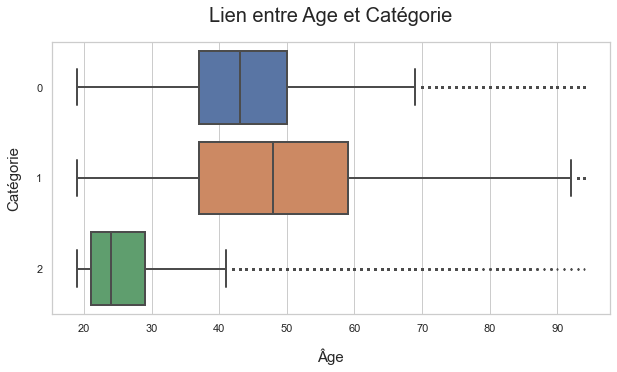

In [104]:
plt.subplots(figsize=(10,5))
ax = sns.boxplot(x="age", y="categ", data=bivariate_df, linewidth=2,fliersize=1.5,orient="h")
sns.set(style="darkgrid")
plt.xlabel("Âge", fontsize = 15, labelpad=15)
plt.ylabel("Catégorie", fontsize = 15, labelpad=15)
plt.title("Lien entre Age et Catégorie", fontsize = 20,loc='center', pad=20)
plt.show()


<u>**Observation**</u><br>
Au 1er regard, il semble y avoir une dépendance entre la catégorie 2 et les personnes jeunes (21 et 29 ans).<br>
Essayons de confirmer cela par le test ANOVA de comparaison de moyennes.

In [105]:
model = ols('age ~ categ', data=bivariate_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
categ,1.489749e+07,2.0,45883.780589,0.0
Residual,1.102818e+08,679329.0,NaN,NaN


<u>**Observation**</u><br>
Les moyennes sont significativement différentes avec un p-value valant 0. Il n'y a pas de risque de se tromper. <br> 
Je vérifie tout de même la validité du test ANOVA en contrôlant les conditions (test de normalité).

**Egalité des variances**

Le test de bartlett permet de tester si les variances sont significativement différentes ou non.

H0 : Les variances de chaque groupe sont égales si p-value > 0.05<br>
Ha : Les variances de chaque groupe ne sont pas toutes égales si p-value < 0.05

In [106]:
bivariate_df.groupby("categ")['age'].agg('var')

categ
0    125.652495
1    240.123223
2     96.003604
Name: age, dtype: float64

In [107]:
bartlett(bivariate_df.age[bivariate_df.categ == 0],
        bivariate_df.age[bivariate_df.categ == 1],
        bivariate_df.age[bivariate_df.categ == 2])

BartlettResult(statistic=nan, pvalue=nan)

<u>**Observation**</u><br>
P-value vaut 0, les variances ne sont pas du tout égales.<br>
On regarde quand même l'égalité des résidus, mais le test Anova ne peut pas être utilisé puisque la condition n'est pas remplie.

**Egalité des résidus**

L’objectif est de s’assurer que les résidus suivent une loi normale afin de ne pas affirmer qu’il existe une différence de moyenne entre les groupes qui serait causée par le hasard.

On utilise le test de Shapiro-Wilk pour tester la normalité des résidus où :

H0 : Les résidus suivent une loi normale si p-value > 0.05<br>
Ha : Les résidus ne suivent pas une loi normale si p-value < 0.05


In [108]:
model = ols('age ~ categ', data=bivariate_df).fit()
shapiro(model.resid)

/Users/laetitia/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9703239798545837, pvalue=0.0)

<u>**Observation**</u><br>
P-value vaut 0, les résidus ne suivent pas de loi normale.

<u>**Conclusion**</u><br>
**Il n'est donc pas conseillé de réaliser une ANOVA car les résultats ne seraient pas fiables (si on disposait d'un petit échantillon).<br>
Il faut passer à un test non paramétrique.**

### Test non paramétrique Kruskal-Wallis

Le test de Kruskal-Wallis est un test robuste non paramétrique. Il n'y a pas besoin de conditions préalables pour l'appliquer.<br>
Il permet de savoir, pour une variable pour laquelle on dispose de plusieurs catégories, si au moins une catégorie diffère.<br>
Comme il s'applique à la médiane, il peut passer en force même si les valeurs ne se répartissent pas selon la loi normale : il remplace ANOVA lorsque l'une des conditions préalables n'a pas été remplie.

In [ ]:
stats.kruskal(bivariate_df.age[bivariate_df.categ=="0"],bivariate_df.age[bivariate_df.categ=="1"],bivariate_df.age[bivariate_df.categ=="2"])

KruskalResult(statistic=79350.86927924873, pvalue=0.0)

**<u>Conclusion</u><br>
On rejette l'hypothèse nulle et on peut considérer sans risque qu'il existe un lien entre l'âge et la catégorie.<br>
On le voit bien sur le graphique, la catégorie des plus jeunes, jusqu'à 39 ans, achètent principalement des livres de la catégorie 2.**

In [ ]:
age_range_categ_dependency=pd.crosstab(bivariate_df.age_range,bivariate_df.categ)
age_range_categ_dependency

In [ ]:
age_range_categ_dependency=pd.crosstab(bivariate_df.age_range,bivariate_df.categ)
age_range_categ_dependency

In [ ]:
Khi2_obs, p, dof, expected = chi2_contingency(age_range_categ_dependency)

print(f"""chi² : {Khi2_obs}
p-value : {p}
Degré de liberté : {dof}
""")


**<u>Conclusion</u><br>
La conclusione est identique à la précédente.<br>**

## Lien entre : âge et montant total des achats / âge et panier moyen
Analyse portant sur des variables de types quantitatives (âge, panier moyen et total des achats).

### Test de corrélation Spearman

Je vais avoir besoin de calculer le panier moyen et le montant total des achats.<br>

**<u>Méthode</u>**<br>
Ajout de 2 colonnes à mon dataframe:
- Calcul du panier moyen (par client) : CA / Nombre de commandes => Utilisation de la fonction mean
- Montant total des achats (par client) : Somme des achats


Question : Y a-t-il un lien entre l’âge des clients et la taille du panier moyen, et l'âge du client et le montant total des achats ?<br>
- H0 : Variables indépendantes si p-value > alpha<br>
- H1 : Variables dépendantes si p-value < alpha<br>
- Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

Si p-value est inférieur à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.


In [210]:
age_basket_df=main_df.copy()

In [211]:
age_basket_df.head(1)

,id_prod,date,session_id,client_id,sex,birth,price,categ,purchase_year,purchase_month,purchase_year_month,age,age_range
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,2022,05,2022-05,37,30-44


In [212]:
age_basket_df=age_basket_df.groupby(['client_id', 'age']).agg(avg_basket_size=('price','mean'),total_purchase=('price','sum')).reset_index()

In [213]:
age_basket_df.head()

,client_id,age,avg_basket_size,total_purchase
0,c_1,68,14.312308,558.18
1,c_10,67,23.337931,1353.60
2,c_100,31,31.856250,254.85
3,c_1000,57,18.095120,2261.89
4,c_1001,41,17.773137,1812.86


Avant de réaliser des tests d'indépendance, on projette graphiquement les données 2 à 2

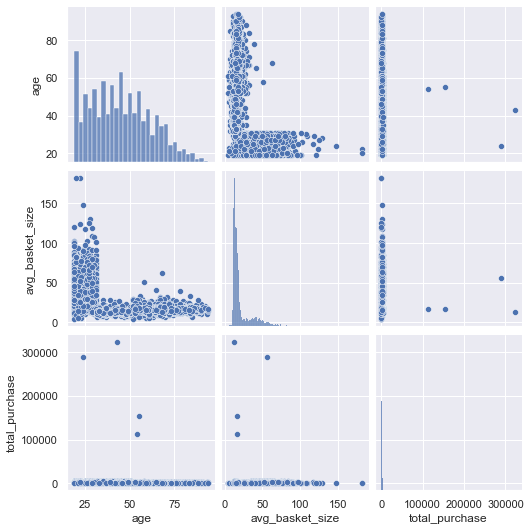

In [115]:
ax=sns.pairplot(age_basket_df.iloc[:,:])

**<u>Observation<u><br>**
On voit clairement 4 outliers qui ont un énorme total d'achat par rapport aux autres clients.<br>
Il s'agit certainement d'entreprises, d'établissement d'enseignement, ou autre, qui n'ont pas les mêmes besoins que les particuliers : nous n'avons pas d'autres informations à ce sujet.<br>
Il faut les identifier et les supprimer pour cette partie du test, mais je les laisse dans le reste des analyses, notament univariées, car il n'y a que 4 clients identifiés :<br>
ça ne fausse pas vraiment les informations de répartition de sexe, de genre, d'âge,...et il est important de les conserver pour le CA.<br>
On ne peut donc pas les ignorer.

J'identifie les clients outliers pour ensuite les supprimer.

In [117]:
outliers_client_df=main_df.groupby('client_id', as_index=False).agg(total_achat=('price','sum')).sort_values("total_achat").tail(4)
outliers_client=outliers_client_df.iloc[:,0]
outliers_client

2724    c_3454
6337    c_6714
4388    c_4958
677     c_1609
Name: client_id, dtype: object

In [118]:
age_basket_df.drop(outliers_client.index, inplace=True)

Vérification de la bonne prise en compte de la suppression

In [203]:
age_basket_df

,client_id,age,avg_basket_size,total_purchase
0,c_1,68,14.312308,558.18
1,c_10,67,23.337931,1353.60
2,c_100,31,31.856250,254.85
3,c_1000,57,18.095120,2261.89
4,c_1001,41,17.773137,1812.86
...,...,...,...,...
8595,c_995,68,13.529286,189.41
8596,c_996,53,17.111368,1625.58
8597,c_997,29,25.254407,1490.01
8598,c_998,22,52.450566,2779.88


In [120]:
age_basket_df[age_basket_df.client_id=='c_3454']

,client_id,age,avg_basket_size,total_purchase


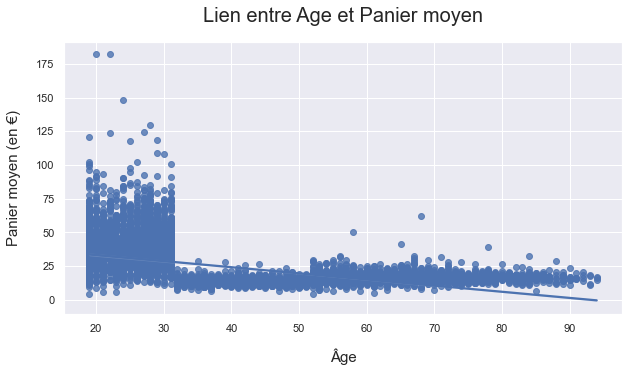

In [121]:
plt.subplots(figsize=(10,5))
sns.regplot(x=age_basket_df["age"], y=age_basket_df["avg_basket_size"])
sns.set(style="darkgrid")
plt.xlabel("Âge", fontsize = 15, labelpad=15)
plt.ylabel("Panier moyen (en €)", fontsize = 15, labelpad=15)
plt.title("Lien entre Age et Panier moyen", fontsize = 20,loc='center', pad=20)
plt.show()

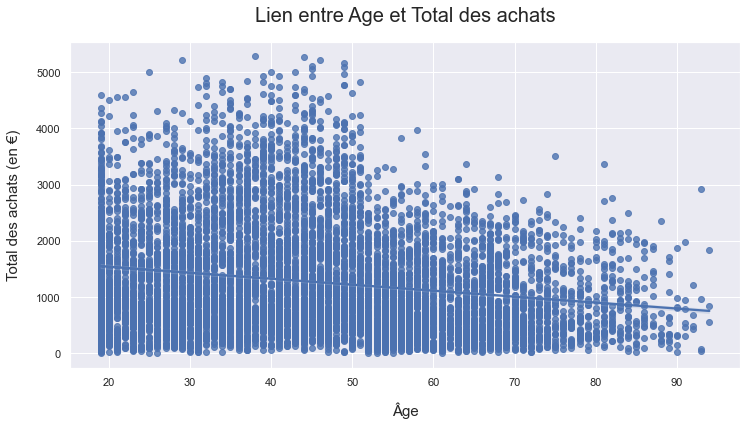

In [122]:
plt.subplots(figsize=(12,6))
sns.regplot(data=age_basket_df, x="age", y="total_purchase")
sns.set(style="darkgrid")
plt.xlabel("Âge", fontsize = 15, labelpad=15)
plt.ylabel("Total des achats (en €)", fontsize = 15, labelpad=15)
plt.title("Lien entre Age et Total des achats", fontsize = 20,loc='center', pad=20)
plt.show()

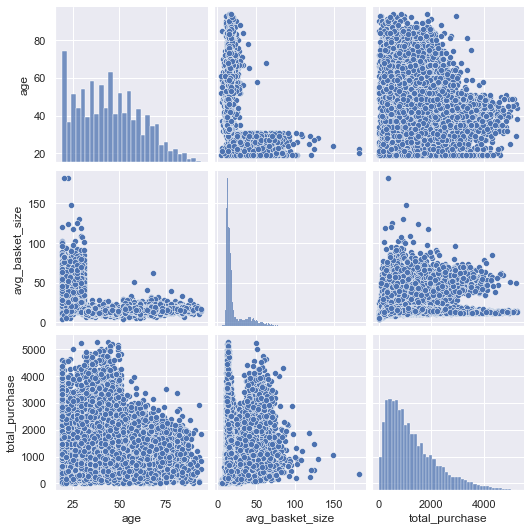

In [123]:
ax=sns.pairplot(age_basket_df.iloc[:,:])

Mise en place de la matrice de corrélation avec la méthode Spearman (car nos données ne sont pas normalisées).

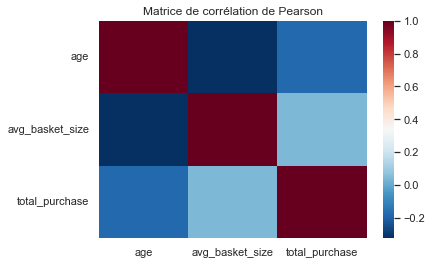

In [124]:
df_corr = age_basket_df.corr(method="spearman")

ax = sns.heatmap(df_corr, cmap = 'RdBu_r').set_title("Matrice de corrélation de Pearson")

Amélioration de la matrice de corrélation en supprimant la partie haute du triangle qui est redondante, et en ajoutant des paramètres d'affichage (couleur, échelle, résultat corrélation).

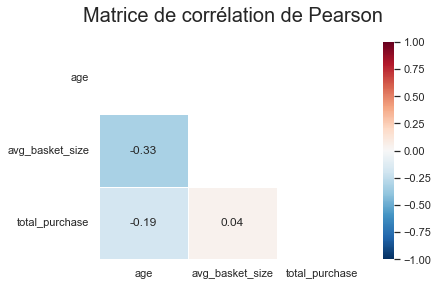

In [125]:
mask = np.triu(np.ones_like(age_basket_df.corr(),dtype=bool))
sns.set(style="whitegrid")
sns.heatmap(df_corr, cmap = 'RdBu_r', mask=mask, annot=True, center=0, vmin=-1,vmax=1, fmt=".2f", linewidths=1)

plt.title("Matrice de corrélation de Pearson", fontsize = 20,loc='center', pad=20)
plt.show()

In [126]:
print(f"""Age vs. Panier moyen : {spearmanr(age_basket_df.age,age_basket_df.avg_basket_size)}
Age vs Total achat : {spearmanr(age_basket_df.age,age_basket_df.total_purchase)}""")

Age vs. Panier moyen : SpearmanrResult(correlation=-0.3261618355177031, pvalue=3.3241215627402095e-212)
Age vs Total achat : SpearmanrResult(correlation=-0.1850724830169425, pvalue=4.229007870955309e-67)


**<u>Conclusion</u><br>
La matrice de corrélation nous montre qu'il y a un lien entre l'âge et le panier moyen, et l'âge et le total des achats.<br>
Les 19-30 ans ont le plus gros panier moyen, le total des achats esrt plus large et concerne les 19-50 ans.**

In [127]:
purchase_freq=main_df.copy()
purchase_freq=purchase_freq.groupby(["age","purchase_year_month"]).agg(purchase_frequency=('purchase_year_month','count')).reset_index()
purchase_freq

,age,purchase_year_month,purchase_frequency
0,19,2021-03,596
1,19,2021-04,581
2,19,2021-05,646
3,19,2021-06,645
4,19,2021-07,683
...,...,...,...
1819,94,2022-10,10
1820,94,2022-11,15
1821,94,2022-12,13
1822,94,2023-01,14


In [128]:
def frequency(df):
    for i in range (0, len(df)):
        
    

IndentationError: expected an indented block (2589360376.py, line 4)

In [129]:
main_df.sort_values(["session_id", "client_id"]).head(100)

,id_prod,date,session_id,client_id,sex,birth,price,categ,purchase_year,purchase_month,purchase_year_month,age,age_range
480501,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,f,1967,11.99,0,2021,03,2021-03,56,45-64
138881,1_635,2021-03-01 00:10:33.163037,s_10,c_2218,f,1970,26.99,1,2021,03,2021-03,53,45-64
359999,0_1030,2021-03-01 04:12:43.572994,s_100,c_3854,f,1978,13.73,0,2021,03,2021-03,45,45-64
578652,0_1451,2021-03-01 04:43:58.025677,s_100,c_3854,f,1978,19.99,0,2021,03,2021-03,45,45-64
87789,0_1438,2021-03-03 03:25:12.320225,s_1000,c_1014,m,1989,9.31,0,2021,03,2021-03,34,30-44
142827,0_1625,2021-03-03 02:38:09.568389,s_1000,c_1014,m,1989,5.99,0,2021,03,2021-03,34,30-44
377730,0_1590,2021-03-03 02:49:03.169115,s_1000,c_1014,m,1989,18.93,0,2021,03,2021-03,34,30-44
542598,0_1449,2021-03-03 03:18:58.492283,s_1000,c_1014,m,1989,4.99,0,2021,03,2021-03,34,30-44
219941,0_1324,2021-03-22 17:58:20.634519,s_10000,c_476,f,1989,3.93,0,2021,03,2021-03,34,30-44
345882,0_1418,2021-03-22 18:15:03.831240,s_10000,c_476,f,1989,8.57,0,2021,03,2021-03,34,30-44


## Lien entre le genre des clients et les catégories des livres achetés 

Il s'agit ici d'analyser 2 variables qualitatives.


### Test de Khi²

L'intérêt du test du **Khi²** est de mesurer l'indépendance entre deux variables qualitatives à partir du tableau de contigence.

**Méthode :**

On pose les hypothèses de départ :

- H0 : Variables indépendantes si p-value > alpha<br>
- H1 : Variables dépendantes si p-value < alpha<br>
- Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

Si p-value est inférieur à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.

In [163]:
sex_categ=bivariate_df.groupby(["categ","sex"], as_index=False).agg(total=("client_id",'count'))
sex_categ

,categ,sex,total
0,0,f,206220
1,0,m,209460
2,1,f,114899
3,1,m,112270
4,2,f,17283
5,2,m,19200


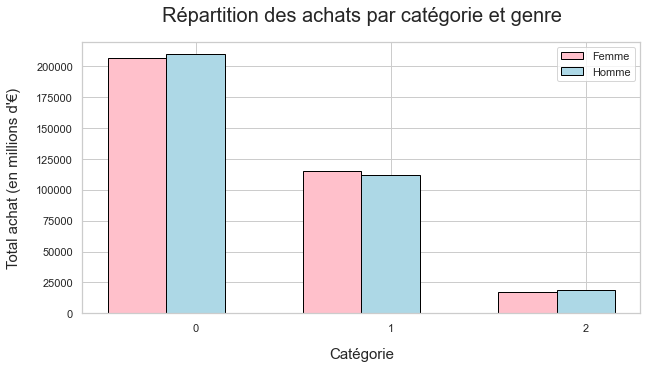

In [164]:
fig = plt.subplots(figsize=(10, 5))

# width of the bars
barWidth = 0.3
 
# Determine the height of the women bars
w_bars = sex_categ["total"][sex_categ["sex"]=="f"]
 
# Determine the height of the men bars
m_bars = sex_categ["total"][sex_categ["sex"]=="m"]

# The x position of bars
r1 = np.arange(len(w_bars))
r2 = [x + barWidth for x in r1]
 
# Create women bars
plt.bar(x=r1, height=w_bars, width =barWidth, color = 'pink', edgecolor = 'black', label='Femme')
 
# Create men bars
plt.bar(x=r2, height=m_bars, width = barWidth,  color = 'lightblue', edgecolor = 'black',   label='Homme')
 
# general layout
plt.xticks(ticks=[r + barWidth for r in range(len(m_bars))], labels=[sex_categ["categ"][sex_categ["sex"]=="m"]][0])
plt.ylabel("Total achat (en millions d'€)", fontsize = 15,labelpad=15)
plt.xlabel("Catégorie", fontsize = 15,labelpad=15)
plt.title("Répartition des achats par catégorie et genre", fontsize = 20,loc='center', pad=20)
plt.legend()
 
# Show graphic
plt.show()

Tableau de contingence

In [165]:
sex_categ_contingency=pd.crosstab(bivariate_df.categ,bivariate_df.sex)
sex_categ_contingency

sex,f,m
categ,,
0,206220,209460
1,114899,112270
2,17283,19200


In [166]:
Khi2_obs, p, dof, expected = chi2_contingency(sex_categ_contingency)

print(f"""chi² : {Khi2_obs}
p-value : {p}
Degré de liberté : {dof}
""")

chi² : 147.00253568681114
p-value : 1.1989607410166063e-32
Degré de liberté : 2



**<u>Conclusion</u><br>
On peut en déduire, avec un risque quasi nul d'erreur, que les variables genre et catégorie de livres sont liées.
La catégorie 0 estla plus achetée par les hommes et les femmes.**

## Lien entre l'âge et la fréquence d'achat
L'analyse porte sur 2 variables quantitatives

### Test de corrélation de Spearman

**Méthode :**<br>
Je calcule la fréquence d'achat en comptabilisant le nombre de session par client que je divise par le nombre de mois.

**Hypothèses :<br>**
- H0 : Variables indépendantes si p-value > alpha<br>
- H1 : Variables dépendantes si p-value < alpha<br>
- Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

Si p-value est inférieur à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.



In [229]:
nb_months=len(main_df.purchase_year_month.unique())
nb_months

24

Je fais d'abord un groupby sur le client et la session pour ne garder que les achats d'une même commande.<br>
Je divise ce chiffre par mon unité de temps pour avoir la fréquence d'achat.

In [239]:
age_purchase_freq=main_df[["client_id","session_id","age"]].copy().groupby(['client_id','age'], as_index=False).agg(nb_session=('session_id','count')).sort_values("nb_session")
age_purchase_freq["purchase_freq"]=age_purchase_freq.nb_session/nb_months

Je supprime les clients outliers identifiés plus haut.

In [240]:
age_purchase_freq.drop(outliers_client.index, inplace=True)

In [241]:
age_purchase_freq.head()

,client_id,age,nb_session,purchase_freq
3576,c_4223,72,1,0.041667
694,c_1624,31,1,0.041667
1556,c_240,25,1,0.041667
4044,c_4648,19,1,0.041667
5868,c_6292,31,1,0.041667


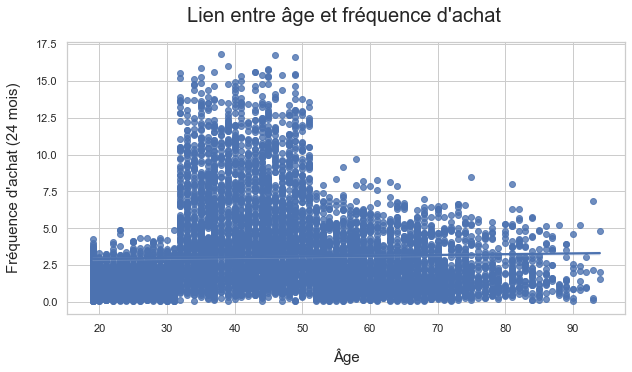

In [242]:
plt.subplots(figsize=(10,5))
sns.regplot(x=age_purchase_freq["age"], y=age_purchase_freq["purchase_freq"])
sns.set(style="darkgrid")
plt.xlabel("Âge", fontsize = 15, labelpad=15)
plt.ylabel("Fréquence d'achat (24 mois)", fontsize = 15, labelpad=15)
plt.title("Lien entre âge et fréquence d'achat ", fontsize = 20,loc='center', pad=20)
plt.show()

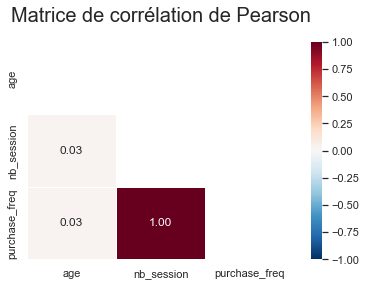

In [243]:
mask = np.triu(np.ones_like(age_purchase_freq.corr(),dtype=bool))
sns.set(style="whitegrid")
sns.heatmap(age_purchase_freq.corr(), cmap = 'RdBu_r', mask=mask, annot=True, center=0, vmin=-1,vmax=1, fmt=".2f", linewidths=1)

plt.title("Matrice de corrélation de Pearson", fontsize = 20,loc='center', pad=20)
plt.show()

In [244]:
print(f"Age vs. Fréquence d'achat : {spearmanr(age_purchase_freq.age,age_purchase_freq.purchase_freq)}")

Age vs. Fréquence d'achat : SpearmanrResult(correlation=0.12829742372670497, pvalue=7.088426379034454e-33)


**<u>Conclusion</u><br>
Le graphique et le résultat du test confirment le lien entre la fréquence d'achat et l'âge : ce sont les 30-50 ans qui achètent le plus.**